# Hackaton

## 1. Имеющиеся изображения

### Исходный список
1. Расположен в папке '/home/kirillk/datasets/hackaton_2022/'
    - 'texture.jpg'

## 2. Загрузка библиотек

In [92]:
import cv2
import imutils
import numpy as np
import matplotlib.pyplot as plt
import os
import math
from PIL import Image
from pyzbar import pyzbar

import pytesseract
from pytesseract import Output
from typing import List

import re
import base64

## 3. Глобальные переменные

In [5]:
!pwd

/home/kirillk/PycharmProjects/useful_notebooks/ocr


In [6]:
FILE_PATH = '/home/kirillk/datasets/hackaton_2022/'
RESULT_PATH = '/home/kirillk/datasets/hackaton_2022/results/'

## 4. Необходимые функции

In [4]:
def find_contour(gray_image, threshold=100):
    _, thresh = cv2.threshold(gray_image, threshold, 255, 0)  # 160
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    max_contour = 0
    num_of_contour = None

    for num, i in enumerate(contours):
        if len(i) > max_contour:
            max_contour = len(i)
            num_of_contour = num
    return contours[num_of_contour]    

In [5]:
def detect_shape(contour):
    """Returns the shape (e.g. 'triangle', 'square') from the contour"""

    detected_shape = '-----'

    # Calculate perimeter of the contour:
    perimeter = cv2.arcLength(contour, True)

    # Get a contour approximation:
    contour_approx = cv2.approxPolyDP(contour, 0.03 * perimeter, True)

    # Check if the number of vertices is 3. In this case, the contour is a triangle
    if len(contour_approx) == 3:
        detected_shape = 'triangle'

    # Check if the number of vertices is 4. In this case, the contour is a square/rectangle
    elif len(contour_approx) == 4:

        # We calculate the aspect ration from the bounding rect:
        x, y, width, height = cv2.boundingRect(contour_approx)
        aspect_ratio = float(width) / height

        # A square has an aspect ratio close to 1 (comparison chaining is used):
        if 0.90 < aspect_ratio < 1.10:
            detected_shape = "square"
        else:
            detected_shape = "rectangle"

    # Check if the number of vertices is 5. In this case, the contour is a pentagon
    elif len(contour_approx) == 5:
        detected_shape = "pentagon"

    # Check if the number of vertices is 6. In this case, the contour is a hexagon
    elif len(contour_approx) == 6:
        detected_shape = "hexagon"

    # The shape as more than 6 vertices. In this example, we assume that is a circle
    else:
        detected_shape = "circle"

    # return the name of the shape and the found vertices
    return detected_shape, contour_approx

## 5. Данные

Список тестовых фото.

In [7]:
test_photo_list = [i for i in os.listdir(FILE_PATH) if i.endswith('jpg')]
test_photo_list

['texture.jpg']

Посмотрм на тестовые фото.

In [9]:
for photo in test_photo_list:
    image = cv2.imread(FILE_PATH + photo)
#     image = cv2.resize(image, (0, 0), fx=0.12, fy=0.12)
    cv2.imshow('Image', image)
    cv2.waitKey()
    cv2.destroyAllWindows()

### Вывод
Все тестовые фото на месте.

## 6. Анализ контуров

In [8]:
# посмотрим на все фото
for photo in test_photo_list:
    im = cv2.imread(FILE_PATH + photo)
    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    doc_contur = find_contour(gray_image=imgray)
    shape, vertices = detect_shape(doc_contur)
    
    img = cv2.polylines(im, [vertices], True, (0,0,255), 10)
    img = cv2.resize(img, (0, 0), fx=0.1, fy=0.1)

    cv2.imshow("Image", img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

### Вывод
Контуры определяются корректно.

## 7. Применим функцию перспективной трансформации.

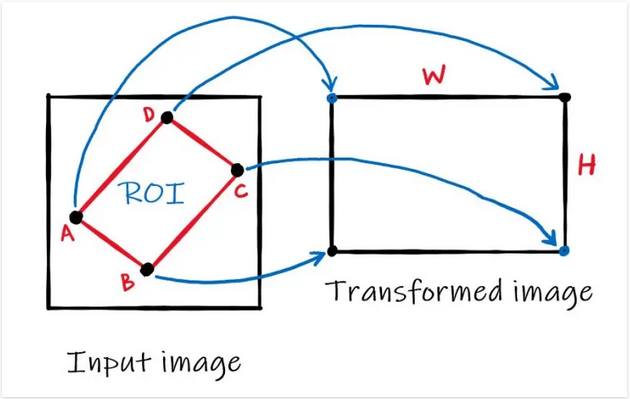

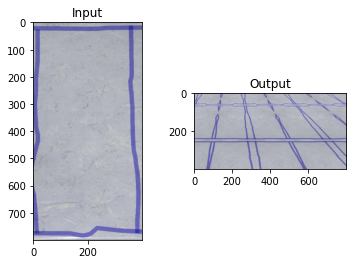

In [68]:
img = cv2.imread(FILE_PATH + 'texture.jpg')[:, 200:600]
rows,cols,ch = img.shape

pts1 = np.float32([[0, 0],[400,0],[0,800],[400,800]])
pts2 = np.float32([[100, 250],[300, 250],[0,800],[400,800]])

M = cv2.getPerspectiveTransform(pts1,pts2)
dst = cv2.warpPerspective(img, M, (800,400), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()

In [90]:
def perspective_transform(image, 
                          pts2: List[int]):

    pts1 = np.float32([[0, 0],
                       [image.shape[1], 0],
                       [0, image.shape[0]],
                       [image.shape[1], image.shape[0]]])
    pts2 = np.float32(pts2)

    M = cv2.getPerspectiveTransform(pts1,pts2)
    dst = cv2.warpPerspective(image, 
                              M,
                              (image.shape[0],
                               image.shape[1]),
#                               (1000, 1000),
                              flags=cv2.INTER_LINEAR,
                              borderMode=cv2.BORDER_WRAP)
#                               borderMode=cv2.BORDER_REFLECT_101)
    return dst

In [ ]:
def perspective_transform(image, 
                          indent: float,
                          y_coef: float,
                          x_coef: float,
                          perspective_coef: float,
                          out_shape):

    pts1 = np.float32([[0, 0],
                       [image.shape[1], 0],
                       [0, image.shape[0]],
                       [image.shape[1], image.shape[0]]])
    pts2 = [
        [out_shape[1] - indent * out_shape[1] - image.shape[1] * x_coef + image.shape[1] * perspective_coef,
         out_shape[0] - image.shape[0] * y_coef],
        [out_shape[1] - indent * out_shape[1] - image.shape[1] * perspective_coef, 
         out_shape[0] - image.shape[0] * y_coef],
        [out_shape[1] - indent * out_shape[1] - image.shape[1] * x_coef, 
         out_shape[0]],
        [out_shape[1] - indent * out_shape[1],
         out_shape[0]]]
    pts2 = np.float32(pts2)

    M = cv2.getPerspectiveTransform(pts1,pts2)
    dst = cv2.warpPerspective(image, 
                              M,
                              (out_shape[1],
                              out_shape[0]),
                              flags=cv2.INTER_LINEAR,
                              borderMode=cv2.BORDER_WRAP)

    background_of_shadows = np.zeros_like(dst)
    i=0
    k=250
    for _ in range(50):
        background_of_shadows[0+i:50+i, :] = (255 - k, 255-k, 255 - k)
        i += 20
        k -= 4

    im = cv2.addWeighted(background_of_shadows, 0.5, dst, 0.5, 0.5)
    return im

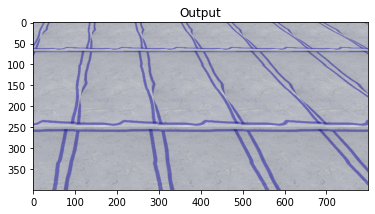

In [91]:
img = cv2.imread(FILE_PATH + 'texture.jpg')[:, 200:600]
img = perspective_transform(img, [[100, 250],[300, 250],[0,800],[400,800]])
plt.imshow(img)
plt.title('Output')
plt.show()
# cv2.imshow('s', img)
# cv2.waitKey()
# cv2.destroyAllWindows()

In [93]:
base64.decodebytes(FILE_PATH + 'textures.txt')

TypeError: expected bytes-like object, not str

In [17]:
def perspective_transform(src, dst_shape, dst_points):
        """
        Perspective Transform
        :param src: Image to transform.
        :param dst_shape: Tuple of 2 intergers(rows and columns).
        :param dst_points: [[x1, y1], [x2, y2], [x3, y3], [x4, y4]].
        :return: Image after perspective transform.
        """
        img = src.copy()
        h, w = img.shape[:2]
        src_points = np.float32([[0, 0], [w, 0], [w, h], [0, h]])
        dst_points = np.float32(dst_points)
        perspective_mat = cv2.getPerspectiveTransform(src=src_points, dst=dst_points)
        dst = cv2.warpPerspective(img, perspective_mat, (dst_shape[1], dst_shape[0]),
                                  borderValue=0, borderMode=cv2.BORDER_CONSTANT)
        return dst 

In [23]:
img = cv2.imread(FILE_PATH + 'texture.jpg')
# img.shape
image = perspective_transform(img, (600, 600), [[50, 70], [100, 100], [50, 200], [200, 200]])
cv2.imshow('s', image)
cv2.waitKey()
cv2.destroyAllWindows()

In [24]:
def shift_scale_rotate(img, angle, scale, dx, dy):
    height, width = img.shape[:2]

    cc = math.cos(angle/180*math.pi) * scale
    ss = math.sin(angle/180*math.pi) * scale
    rotate_matrix = np.array([[cc, -ss], [ss, cc]])

    box0 = np.array([[0, 0], [width, 0],  [width, height], [0, height], ])
    box1 = box0 - np.array([width/2, height/2])
    box1 = np.dot(box1, rotate_matrix.T) + np.array([width/2+dx*width, height/2+dy*height])

    box0 = box0.astype(np.float32)
    box1 = box1.astype(np.float32)
    mat = cv2.getPerspectiveTransform(box0, box1)
    img = cv2.warpPerspective(img, mat, (width, height),
                              flags=cv2.INTER_LINEAR,
                              borderMode=cv2.BORDER_REFLECT_101)

    return img 

In [37]:
img = cv2.imread(FILE_PATH + 'texture.jpg')
# img.shape
image = shift_scale_rotate(img=img,
                           angle=0,
                           scale=0.2,
                           dx=5,
                           dy=5)
cv2.imshow('s', image)
cv2.waitKey()
cv2.destroyAllWindows()

In [9]:
def perspective_transform(vertices):
    pt_A = vertices[1][0]
    pt_B = vertices[2][0]
    pt_C = vertices[3][0]
    pt_D = vertices[0][0]

    # Here, I have used L2 norm. You can use L1 also.
    width_AD = np.sqrt(((pt_A[0] - pt_D[0]) ** 2) + ((pt_A[1] - pt_D[1]) ** 2))
    width_BC = np.sqrt(((pt_B[0] - pt_C[0]) ** 2) + ((pt_B[1] - pt_C[1]) ** 2))
    maxWidth = max(int(width_AD), int(width_BC))


    height_AB = np.sqrt(((pt_A[0] - pt_B[0]) ** 2) + ((pt_A[1] - pt_B[1]) ** 2))
    height_CD = np.sqrt(((pt_C[0] - pt_D[0]) ** 2) + ((pt_C[1] - pt_D[1]) ** 2))
    maxHeight = max(int(height_AB), int(height_CD))

    input_pts = np.float32([pt_A, pt_B, pt_C, pt_D])
    output_pts = np.float32([[0, 0],
                            [0, maxHeight - 1],
                            [maxWidth - 1, maxHeight - 1],
                            [maxWidth - 1, 0]])
    
    # Compute the perspective transform M
    M = cv2.getPerspectiveTransform(input_pts, output_pts)
    return M, maxWidth, maxHeight

### Тест на первом фото 

In [10]:
im = cv2.imread(FILE_PATH + test_photo_list[0])
imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

doc_contour = find_contour(gray_image=imgray)
shape, vertices = detect_shape(doc_contour)
m, max_width, max_height = perspective_transform(vertices=vertices)
out = cv2.warpPerspective(im, m, (max_width, max_height), flags=cv2.INTER_LINEAR)

out = cv2.resize(out, (0, 0), fx=0.12, fy=0.12)
cv2.imshow('Image', out)
cv2.waitKey()
cv2.destroyAllWindows()

## 8. Тестирование на всех фото

In [11]:
for photo in test_photo_list:
    im = cv2.imread(FILE_PATH + photo)
    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    doc_contour = find_contour(gray_image=imgray)
    shape, vertices = detect_shape(doc_contour)
    m, max_width, max_height = perspective_transform(vertices=vertices)
    out = cv2.warpPerspective(im, m, (max_width, max_height), flags=cv2.INTER_LINEAR)

    out = cv2.resize(out, (0, 0), fx=0.12, fy=0.12)
    cv2.imshow('Image', out)
    cv2.waitKey()
    cv2.destroyAllWindows()

### Вывод:
Все фото корректно повернулись.

## 9. Сохранение результатов работ

In [12]:
counter = 0

for photo in test_photo_list:
    im = cv2.imread(FILE_PATH + photo)
    imgray = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

    doc_contour = find_contour(gray_image=imgray)
    shape, vertices = detect_shape(doc_contour)
    m, max_width, max_height = perspective_transform(vertices=vertices)
    out = cv2.warpPerspective(im, m, (max_width, max_height), flags=cv2.INTER_LINEAR)
    
    cv2.imwrite(f'{RESULT_PATH}{counter}.jpg', out)
    counter += 1

Оценим результат работы.

In [15]:
for photo in os.listdir(RESULT_PATH):
    image = cv2.imread(RESULT_PATH + photo)
    image = cv2.resize(image, (0, 0), fx=0.12, fy=0.12)
    cv2.imshow('Result', image)
    cv2.waitKey()
    cv2.destroyAllWindows()

### Вывод
Все развренутые фото сохранены.

## 10. Тестирование ортогонального поворота (tesseract)

In [16]:
# список фото
photo_result = sorted([photo for photo in os.listdir(RESULT_PATH) if photo.endswith('.jpg')])
photo_result

['0.jpg', '1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg']

In [18]:
%%time
for photo in photo_result:
    try:
        print(f'scan name {photo}')
        print(pytesseract.image_to_osd(RESULT_PATH + photo, output_type=Output.DICT))
    except:
        print(f'error at scan {photo}')

scan name 0.jpg
{'page_num': 0, 'orientation': 90, 'rotate': 270, 'orientation_conf': 2.71, 'script': 'Latin', 'script_conf': 0.44}
scan name 1.jpg
{'page_num': 0, 'orientation': 0, 'rotate': 0, 'orientation_conf': 1.02, 'script': 'Latin', 'script_conf': 2.35}
scan name 2.jpg
{'page_num': 0, 'orientation': 270, 'rotate': 90, 'orientation_conf': 0.96, 'script': 'Latin', 'script_conf': 0.3}
scan name 3.jpg
{'page_num': 0, 'orientation': 90, 'rotate': 270, 'orientation_conf': 1.83, 'script': 'Latin', 'script_conf': 0.61}
scan name 4.jpg
{'page_num': 0, 'orientation': 0, 'rotate': 0, 'orientation_conf': 2.36, 'script': 'Devanagari', 'script_conf': 1.82}
scan name 5.jpg
{'page_num': 0, 'orientation': 0, 'rotate': 0, 'orientation_conf': 2.61, 'script': 'Latin', 'script_conf': 0.68}
CPU times: user 9.25 ms, sys: 62.2 ms, total: 71.4 ms
Wall time: 21.1 s


### Вывод
Ну могло быть и лучше.